# Segmenting and Clustering Neighborhoods in Toronto - KEN

## Prepare Data

### Data Preparation - Part I

#### Use the Notebook to build the code to scrape the following Wikipedia page:
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [1]:
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
import requests # library to handle requests
import folium # map rendering library

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans # import k-means from clustering stage

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
import wikipedia as wp
html = wp.page('List_of_postal_codes_of_Canada:_M').html().encode('UTF-8')

#take only the first table
df = pd.read_html(html)[0]

#### The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood.

In [3]:
#rename the 'Postcode' column to 'PostalCode'
df = df.rename({'Postcode': 'PostalCode'}, axis = 1)
df.head(3)

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods


#### Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [4]:
#remove data with 'Not assigned' in column 'Borough'
df = df[df['Borough'] != 'Not assigned']
df.head(3)

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Combine post code area with multiple neighborhoods into single row with the neighborhoods separated with a comma.

In [5]:
#sort dataframe with 'PostalCode'
df = df.sort_values('PostalCode').reset_index(drop = True)

#combine 'Neighborhood' for 'PostalCode' with multiple neighborhoods
rows_to_drop = []
for i in np.arange(1, len(df)):
    if df['PostalCode'][i] == df['PostalCode'][i-1]:
        df['Neighborhood'][i] = str(df['Neighborhood'][i] + ', ' + df['Neighborhood'][i-1])
        rows_to_drop.append(i-1)

#remove unwanted rows
df = df.drop(rows_to_drop).reset_index(drop = True)
df.head(3)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"West Hill, Morningside, Guildwood"


#### If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. 

In [6]:
#identify 'Neighborhood' with 'Not assigned'
print(df[df['Neighborhood'] == 'Not assigned'])

#replace 'Neighborhood' with its 'Borough'
for i in range(len(df)):
    if df['Neighborhood'][i] == 'Not assigned':
        df['Neighborhood'][i] = df['Borough'][i]

#double check
print('\n', df[df['PostalCode'] == 'M9A'])

   PostalCode       Borough  Neighborhood
93        M9A  Queen's Park  Not assigned

    PostalCode       Borough  Neighborhood
93        M9A  Queen's Park  Queen's Park


#### Use the .shape method to print the number of rows of the dataframe.

In [7]:
print('Number of rows: {}'.format(df.shape[0]))

Number of rows: 103


### Data Preparation - Part II

#### Given that 'geocoder' package can be very unreliable, in case not able to get the geographical coordinates of the neighborhoods using the Geocoder package, obtain the csv file that has the geographical coordinates of each postal code from this: http://cocl.us/Geospatial_data

In [8]:
# import geocoder 

# # initialize your variable to None
# lat_lng_coords = None

# # loop until you get the coordinates
# while(lat_lng_coords is None):
#   g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#   lat_lng_coords = g.latlng

# latitude = lat_lng_coords[0]
# longitude = lat_lng_coords[1]

In [9]:
#import the csv with latitude and longitude
df_lat_lon = pd.read_csv('Geospatial_Coordinates.csv')
df_lat_lon.head(3)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711


In [10]:
#inner join both dataframe by their postal code
df_merged = df.join(df_lat_lon.set_index('Postal Code'), on = 'PostalCode')
df_merged.head(3)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"West Hill, Morningside, Guildwood",43.763573,-79.188711


In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_merged['Borough'].unique()),
        df_merged.shape[0]))

The dataframe has 11 boroughs and 103 neighborhoods.


## Explore Neighborhoods in Toronto

#### Use geopy library to get the latitude and longitude values of Toronto City.

In [12]:
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Toronto, Canada'

geolocator = Nominatim(user_agent = "tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [13]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Borough'], df_merged['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare Credentials and Version

In [14]:
CLIENT_ID = '25QN0HTHSVIEFG3L3JFXXFCZWAWJYLFPUTLFZ4FZDLBCLJZ3' # your Foursquare ID
CLIENT_SECRET = 'QLV1K2WHNI5LYXDC4MWPSJHECQZAU4UYCTIDTJJEQPCBPT0H' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 25QN0HTHSVIEFG3L3JFXXFCZWAWJYLFPUTLFZ4FZDLBCLJZ3
CLIENT_SECRET:QLV1K2WHNI5LYXDC4MWPSJHECQZAU4UYCTIDTJJEQPCBPT0H


#### Explore one of the Neighborhoods in Toronto

In [15]:
toronto_data = df_merged.copy()
toronto_data.tail(3)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
100,M9R,Etobicoke,"Martin Grove Gardens, St. Phillips, Kingsview ...",43.688905,-79.554724
101,M9V,Etobicoke,"Silverstone, Thistletown, South Steeles, Mount...",43.739416,-79.588437
102,M9W,Etobicoke,Northwest,43.706748,-79.594054


In [16]:
neighborhood_latitude = toronto_data.loc[102, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[102, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[102, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Northwest are 43.706748299999994, -79.5940544.


#### Get the top 100 venues that are in Northwest within a radius of 500 meters.

In [17]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=25QN0HTHSVIEFG3L3JFXXFCZWAWJYLFPUTLFZ4FZDLBCLJZ3&client_secret=QLV1K2WHNI5LYXDC4MWPSJHECQZAU4UYCTIDTJJEQPCBPT0H&v=20180605&ll=43.706748299999994,-79.5940544&radius=500&limit=100'

In [26]:
#create the GET request URL
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e1c78c078a484001b5e57b2'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 43.711248304499996,
    'lng': -79.58784096674265},
   'sw': {'lat': 43.70224829549999, 'lng': -79.60026783325736}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5273f6f311d2137549494e29',
       'name': 'Economy Rent A Car',
       'location': {'lat': 43.708471,
        'lng': -79.589943,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.708471,
          'lng': -79.589943}],


In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Clean the json and structure it into a *pandas* dataframe.

In [20]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Economy Rent A Car,Rental Car Location,43.708471,-79.589943
1,Saand Rexdale,Drugstore,43.705072,-79.598725


In [21]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

2 venues were returned by Foursquare.


#### Explore All Neighborhoods in Toronto

#### Create function to repeat the same process to all the neighborhoods in Toronto and store it in a data frame

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return nearby_venues

In [28]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude'])

print(toronto_venues.shape)
toronto_venues.head()

(2209, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"West Hill, Morningside, Guildwood",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"West Hill, Morningside, Guildwood",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"West Hill, Morningside, Guildwood",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa


In [29]:
#check how many venues were returned for each neighborhood
pd.DataFrame(toronto_venues['Neighborhood'].value_counts())

,Neighborhood
"Toronto Dominion Centre, Design Exchange",100
St. James Town,100
"Toronto Islands, Union Station, Harbourfront East",100
"Ryerson, Garden District",100
"First Canadian Place, Underground city",100
"King, Richmond, Adelaide",100
"Victoria Hotel, Commerce Court",100
Stn A PO Boxes 25 The Esplanade,95
"Grange Park, Chinatown, Kensington Market",90
Church and Wellesley,84


In [30]:
#find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 273 uniques categories.


## Analyze Each Neighborhood

In [31]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(2209, 273)


,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [32]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(99, 273)


,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.

#### Print each neighborhood along with the top 5 most common venues

In [33]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0             Breakfast Spot   0.2
1                     Lounge   0.2
2  Latin American Restaurant   0.2
3               Skating Rink   0.2
4             Clothing Store   0.2


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                        venue  freq
0                        Park   0.5
1                  Playground   0.5
2                 Yoga Studio   0.0
3                 Men's Store   0.0
4  Modern European Restaurant   0.0


----Alderwood, Long Branch----
                venue  freq
0         Pizza Place  0.22
1  Athletics & Sports  0.11
2         Coffee Shop  0.11
3                 Pub  0.11
4      Sandwich Place  0.11


----Bathurst Quay, Harbourfront West, Island airport, CN Tower, South Niagara, Railway Lands, King and Spadina----
              venue  freq
0  Airport Terminal  0.13
1    Airport Lounge  0.13
2   Airport Service  0.13
3               Bar  0.07
4  Sculpture Garden  0.07


----Bayview V

                             venue  freq
0                              Bar   1.0
1                      Yoga Studio   0.0
2               Mexican Restaurant   0.0
3  Molecular Gastronomy Restaurant   0.0
4       Modern European Restaurant   0.0


----Hillcrest Village----
                      venue  freq
0               Golf Course   0.2
1  Mediterranean Restaurant   0.2
2        Athletics & Sports   0.2
3                      Pool   0.2
4                   Dog Run   0.2


----Humber Bay Shores, New Toronto, Mimico South----
                venue  freq
0                Café  0.17
1         Pizza Place  0.08
2              Bakery  0.08
3          Restaurant  0.08
4  Seafood Restaurant  0.08


----Humber Summit----
                        venue  freq
0         Empanada Restaurant   0.5
1                 Pizza Place   0.5
2                 Yoga Studio   0.0
3  Modern European Restaurant   0.0
4           Mobile Phone Shop   0.0


----Humewood-Cedarvale----
          venue  freq
0       

                  venue  freq
0                 Trail   0.2
1     Health Food Store   0.2
2  Other Great Outdoors   0.2
3                   Pub   0.2
4           Yoga Studio   0.0


----The Danforth West, Riverdale----
                    venue  freq
0        Greek Restaurant  0.21
1             Coffee Shop  0.10
2      Italian Restaurant  0.07
3          Ice Cream Shop  0.07
4  Furniture / Home Store  0.05


----The Junction South, High Park----
                venue  freq
0                 Bar  0.09
1  Mexican Restaurant  0.09
2                Café  0.09
3     Thai Restaurant  0.09
4         Music Venue  0.04


----The Kingsway, Montgomery Road, Old Mill North----
           venue  freq
0           Park  0.33
1          River  0.33
2     Smoke Shop  0.33
3    Yoga Studio  0.00
4  Metro Station  0.00


----Thorncliffe Park----
               venue  freq
0  Indian Restaurant  0.11
1     Sandwich Place  0.11
2       Burger Joint  0.11
3        Yoga Studio  0.06
4               Bank  0.0

#### Create new dataframe and display the top 10 venues for each neighborhood

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [113]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Skating Rink,Clothing Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
1,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
2,"Alderwood, Long Branch",Pizza Place,Skating Rink,Gym,Coffee Shop,Pharmacy,Athletics & Sports,Pub,Sandwich Place,Women's Store,Doner Restaurant
3,"Bathurst Quay, Harbourfront West, Island airpo...",Airport Lounge,Airport Service,Airport Terminal,Harbor / Marina,Bar,Sculpture Garden,Airport,Airport Food Court,Airport Gate,Boutique
4,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Women's Store


## Cluster Neighborhoods

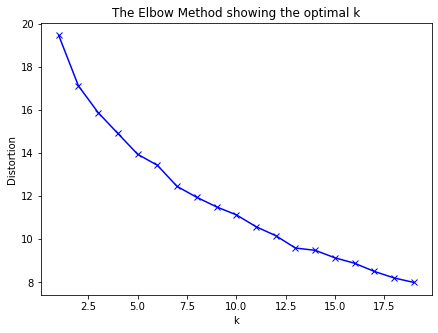

In [110]:
#use elbow method to determine number of clusters
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
distortions = []

K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(7,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [114]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0, n_init = 50, max_iter = 500).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 0, 0, 0, 0, 0, 0, 0, 4])

In [115]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.tail() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
98,M9N,York,Weston,43.706876,-79.518188,4.0,Park,Convenience Store,Women's Store,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
99,M9P,Etobicoke,Westmount,43.696319,-79.532242,0.0,Pizza Place,Middle Eastern Restaurant,Sandwich Place,Intersection,Coffee Shop,Chinese Restaurant,Women's Store,Donut Shop,Dog Run,Doner Restaurant
100,M9R,Etobicoke,"Martin Grove Gardens, St. Phillips, Kingsview ...",43.688905,-79.554724,0.0,Mobile Phone Shop,Pizza Place,Sandwich Place,Bus Line,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Women's Store
101,M9V,Etobicoke,"Silverstone, Thistletown, South Steeles, Mount...",43.739416,-79.588437,0.0,Grocery Store,Fast Food Restaurant,Pharmacy,Video Store,Pizza Place,Fried Chicken Joint,Beer Store,Sandwich Place,Women's Store,Donut Shop
102,M9W,Etobicoke,Northwest,43.706748,-79.594054,0.0,Rental Car Location,Drugstore,Women's Store,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Dim Sum Restaurant


In [116]:
#check for missing value
toronto_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 16 columns):
PostalCode                103 non-null object
Borough                   103 non-null object
Neighborhood              103 non-null object
Latitude                  103 non-null float64
Longitude                 103 non-null float64
Cluster Labels            100 non-null float64
1st Most Common Venue     100 non-null object
2nd Most Common Venue     100 non-null object
3rd Most Common Venue     100 non-null object
4th Most Common Venue     100 non-null object
5th Most Common Venue     100 non-null object
6th Most Common Venue     100 non-null object
7th Most Common Venue     100 non-null object
8th Most Common Venue     100 non-null object
9th Most Common Venue     100 non-null object
10th Most Common Venue    100 non-null object
dtypes: float64(3), object(13)
memory usage: 13.0+ KB


In [117]:
#remove away the missing value
toronto_merged.dropna(inplace = True)
#convert the type of 'Cluster Labels' to int
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
toronto_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 102
Data columns (total 16 columns):
PostalCode                100 non-null object
Borough                   100 non-null object
Neighborhood              100 non-null object
Latitude                  100 non-null float64
Longitude                 100 non-null float64
Cluster Labels            100 non-null int32
1st Most Common Venue     100 non-null object
2nd Most Common Venue     100 non-null object
3rd Most Common Venue     100 non-null object
4th Most Common Venue     100 non-null object
5th Most Common Venue     100 non-null object
6th Most Common Venue     100 non-null object
7th Most Common Venue     100 non-null object
8th Most Common Venue     100 non-null object
9th Most Common Venue     100 non-null object
10th Most Common Venue    100 non-null object
dtypes: float64(2), int32(1), object(13)
memory usage: 12.9+ KB


In [118]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine Clusters

In [119]:
toronto_merged[toronto_merged['Cluster Labels']==0]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M1E,Scarborough,"West Hill, Morningside, Guildwood",43.763573,-79.188711,0,Medical Center,Breakfast Spot,Spa,Rental Car Location,Mexican Restaurant,Pizza Place,Electronics Store,Intersection,Women's Store,Dog Run
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Korean Restaurant,Insurance Office,Women's Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Caribbean Restaurant,Bakery,Athletics & Sports,Fried Chicken Joint,Thai Restaurant,Gas Station,Bank,Hakka Restaurant,Electronics Store,Eastern European Restaurant
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0,Grocery Store,Playground,Women's Store,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,0,Discount Store,Department Store,Coffee Shop,Hobby Shop,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
7,M1L,Scarborough,"Clairlea, Oakridge, Golden Mile",43.711112,-79.284577,0,Bus Line,Bakery,Park,Fast Food Restaurant,Intersection,Bus Station,Metro Station,Soccer Field,Creperie,Donut Shop
8,M1M,Scarborough,"Cliffside, Scarborough Village West, Cliffcrest",43.716316,-79.239476,0,American Restaurant,Motel,Skating Rink,Movie Theater,Women's Store,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,0,College Stadium,Skating Rink,General Entertainment,Café,Ethiopian Restaurant,Event Space,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dim Sum Restaurant
10,M1P,Scarborough,"Scarborough Town Centre, Dorset Park, Wexford ...",43.757410,-79.273304,0,Indian Restaurant,Pet Store,Light Rail Station,Vietnamese Restaurant,Chinese Restaurant,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop
11,M1R,Scarborough,"Wexford, Maryvale",43.750072,-79.295849,0,Breakfast Spot,Smoke Shop,Bakery,Middle Eastern Restaurant,Women's Store,Dumpling Restaurant,Doner Restaurant,Donut Shop,Drugstore,Electronics Store


In [120]:
toronto_merged[toronto_merged['Cluster Labels']==1]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,M8Y,Etobicoke,"Kingsway Park South East, Mimico NE, Sunnylea,...",43.636258,-79.498509,1,Baseball Field,Women's Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Field
97,M9M,North York,"Emery, Humberlea",43.724766,-79.532242,1,Construction & Landscaping,Baseball Field,Women's Store,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant


In [121]:
toronto_merged[toronto_merged['Cluster Labels']==2]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,2,Bar,Women's Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Field


In [122]:
toronto_merged[toronto_merged['Cluster Labels']==3]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,M5N,Central Toronto,Roselawn,43.711695,-79.416936,3,Garden,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Festival


In [123]:
toronto_merged[toronto_merged['Cluster Labels']==4]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,M1V,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577,4,Park,Playground,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
23,M2P,North York,York Mills West,43.752758,-79.400049,4,Park,Bank,Convenience Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
25,M3A,North York,Parkwoods,43.753259,-79.329656,4,Food & Drink Shop,Park,Women's Store,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
30,M3K,North York,"CFB Toronto, Downsview East",43.737473,-79.464763,4,Park,Airport,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
40,M4J,East York,East Toronto,43.685347,-79.338106,4,Park,Convenience Store,Women's Store,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,4,Park,Tennis Court,Playground,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
50,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,4,Park,Trail,Playground,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
74,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,4,Park,Fast Food Restaurant,Market,Women's Store,Greek Restaurant,Gourmet Shop,Event Space,Gym,Ethiopian Restaurant,Empanada Restaurant
90,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,4,River,Smoke Shop,Park,Comfort Food Restaurant,Comic Shop,Falafel Restaurant,Event Space,Ethiopian Restaurant,Colombian Restaurant,Empanada Restaurant
98,M9N,York,Weston,43.706876,-79.518188,4,Park,Convenience Store,Women's Store,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant


In [124]:
toronto_merged[toronto_merged['Cluster Labels']==5]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,5,Fast Food Restaurant,Women's Store,Eastern European Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store


In [125]:
toronto_merged[toronto_merged['Cluster Labels']==6]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,M2L,North York,"York Mills, Silver Hills",43.75749,-79.374714,6,Cafeteria,Martial Arts Dojo,Women's Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
